# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, tokenizer=None, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `tokenizer`: is the tokenizer and it can be customized by using the lemmatizer of Spacy package
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some reference code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")
# get portion to reduce processing time
train=train.iloc[0:5000]
test=test.iloc[0:5000]

In [79]:
train.head(5)

,Unnamed: 0,label,text
0,17583,1,This makes dull hair look fresh. It's not too ...
1,19745,0,This book took almost two weeks to receive. No...
2,13078,1,As a person who frequents the golf course on a...
3,9954,0,This is a very needed message for the children...
4,16217,1,I purchased the Intex airbed to replace an Aer...


In [80]:
# define the customized tokenizer using spacy package
# you can also use stanza package
# this function tokenize the text and get lemmas

import nltk
import spacy

nlp = spacy.load("en_core_web_sm")

def MyTokenizer(text):
    doc=nlp(text)
    newTokens = []
    
    for word in doc:

        res = word.lemma_
        newTokens.append(res)
    print(newTokens)
    return newTokens

MyTokenizer('Runing in the park and then ran away again fell down')
        
        

['run', 'in', 'the', 'park', 'and', 'then', 'run', 'away', 'again', 'fall', 'down']


['run',
 'in',
 'the',
 'park',
 'and',
 'then',
 'run',
 'away',
 'again',
 'fall',
 'down']

In [81]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y, tokenizer=None, model_type="svm", min_df = 1,stop_words=None, print_result = True, algorithm_para=1.0):
    
    # initialize
    tfidf_vect = TfidfVectorizer(stop_words=stop_words,min_df=min_df)
    
    # generate 
    dtm=tfidf_vect.fit_transform(train_docs)
    
    if(model_type=='svm'):
        clf= svm.LinearSVC(C=algorithm_para)
    else:
        clf= MultinomialNB(alpha=algorithm_para)
        
    clf.fit(dtm,train_y)
    
    # transform 
    dtm_test=tfidf_vect.transform(test_docs)
    
    predicted=clf.predict(dtm_test)
    
    # calculate 
    cf=classification_report(test_y,predicted)
    
   # auc
    binary_y = np.where(test_y,1,0)
    
    if(model_type=='svm'):
        predict_p=clf.decision_function(dtm_test)
        fpr, tpr, thresholds = roc_curve(binary_y, predict_p, pos_label=1)
    else:
        predict_p=clf.predict_proba(dtm_test)
        fpr, tpr, thresholds = roc_curve(binary_y, predict_p[:,1], pos_label=1)
    
    # prc
    if(model_type=='svm'):
        precision, recall, thresholds = precision_recall_curve(binary_y, predict_p, pos_label=1)
    else:
        precision, recall, thresholds = precision_recall_curve(binary_y, predict_p[:,1], pos_label=1)
        
    if(print_result):
        print(cf)
        
    auc_score=auc(fpr, tpr)
    
    if(model_type=='svm'):
        prc_score=average_precision_score(binary_y,predict_p)
    else:
        prc_score=average_precision_score(binary_y,predict_p[:,1])
        
    if(print_result):
        print("AUC: {:.2%}".format(auc_score),"PRC: {:.2%}".format(prc_score))
    
    # line charts 
        if(model_type=='svm'):
            plt.figure();
            plt.plot(fpr, tpr, color='darkorange', lw=2);
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
            plt.xlim([0.0, 1.0]);
            plt.ylim([0.0, 1.05]);
            plt.xlabel('False Positive Rate');
            plt.ylabel('True Positive Rate');
            plt.title('svm-AUC');
            plt.show();
    
            plt.figure();
            plt.plot(recall, precision, color='darkorange', lw=2);
            plt.xlim([0.0, 1.0]);
            plt.ylim([0.0, 1.05]);
            plt.xlabel('Recall');
            plt.ylabel('Precision');
            plt.title('svm-PRC');
            plt.show();
        else:
            plt.figure();
            plt.plot(fpr, tpr, color='darkorange', lw=2);
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
            plt.xlim([0.0, 1.0]);
            plt.ylim([0.0, 1.05]);
            plt.xlabel('False Positive Rate');
            plt.ylabel('True Positive Rate');
            plt.title('nb-AUC');
            plt.show();

            plt.figure();
            plt.plot(recall, precision, color='darkorange', lw=2);
            plt.xlim([0.0, 1.0]);
            plt.ylim([0.0, 1.05]);
            plt.xlabel('Recall');
            plt.ylabel('Precision');
            plt.title('nb-PRC'); 
            plt.show();

    return auc_score, prc_score
    

    
    

   

    

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       509
           1       0.80      0.83      0.82       491

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

AUC: 90.08% PRC: 89.92%


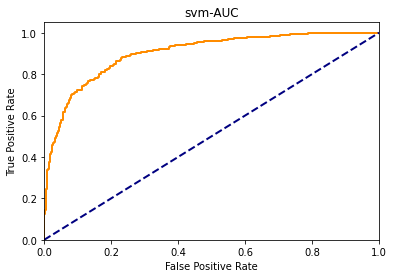

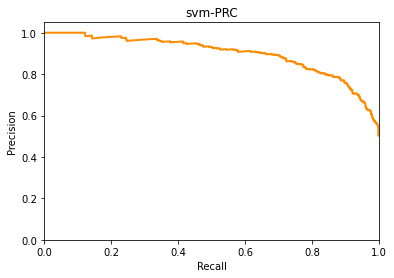

In [82]:
auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], model_type='svm',  min_df = 1, stop_words='english',   print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       509
           1       0.84      0.84      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.67% PRC: 90.97%


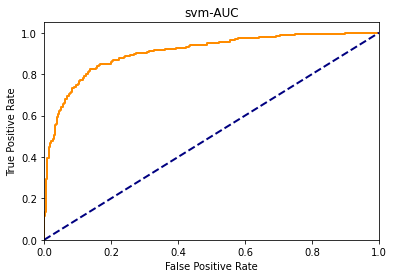

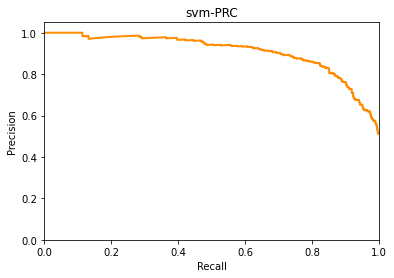

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       509
           1       0.84      0.84      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.67% PRC: 90.97%


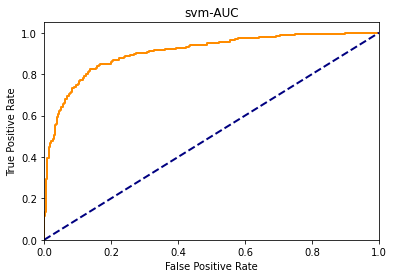

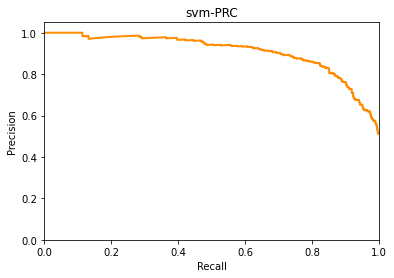

In [83]:
# Test the function with 'svm'
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='svm',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='svm', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       509
           1       0.81      0.80      0.80       491

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

AUC: 88.55% PRC: 88.69%


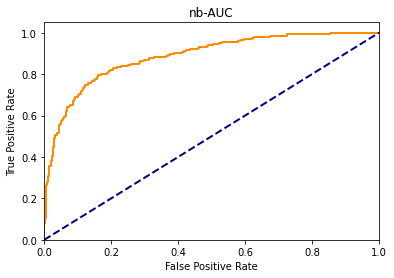

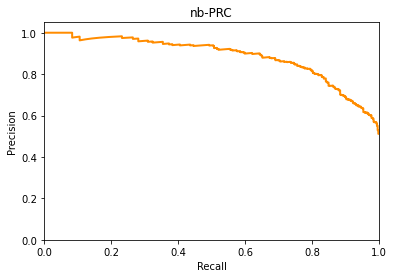

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       509
           1       0.81      0.80      0.80       491

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

AUC: 88.55% PRC: 88.69%


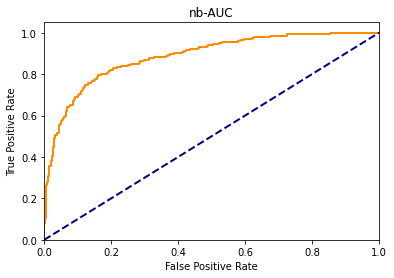

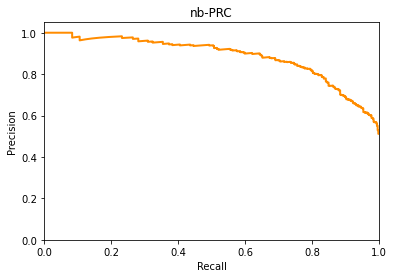

In [84]:
# Test the function with 'nb' 
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='nb',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)



auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='nb', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.1,0.5,1]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 (default tokenizer) `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [85]:
# Define grade search function

def search_para(docs, y):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', svm.LinearSVC())
                   ])
    
    parameters = {'tfidf__min_df':[1, 2,5],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.1, 0.5,1],}
    
    metric =  "f1_macro"
    
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5, n_jobs=-1)
    gs_clf = gs_clf.fit(docs,y)

    return gs_clf.best_params_

    
    
  

    


In [86]:
search_para(train["text"], train["label"])

{'clf__C': 0.5, 'tfidf__min_df': 1, 'tfidf__stop_words': None}

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       509
           1       0.84      0.85      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.91% PRC: 91.29%


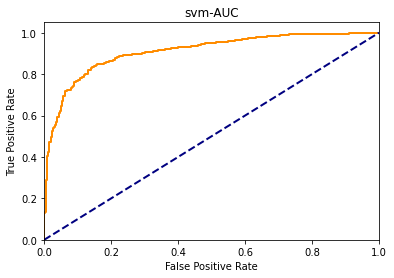

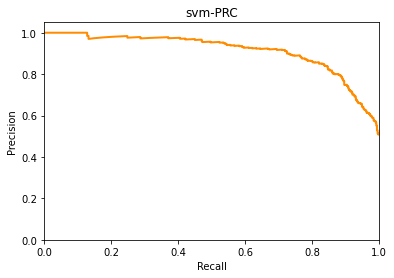

In [87]:
# call the function with the best parameters

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None, model_type='svm',  min_df = 1, stop_words=None,\
                                    print_result=True, algorithm_para=0.5)
# Please answer the questions

## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and  `model_type='nb'` and `stop_words='english'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [88]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):
    
    svm_s=[];
    nb_s=[];
    col=[];
    
    for i in range(500,len(train_docs)+1,500):
        col.append(i);
        
        auc_score,pcr_score= create_model(train_docs[0:i], train_y[0:i], test_docs, test_y,tokenizer=None, model_type='svm', stop_words = None, min_df = 2, print_result=False, algorithm_para=1.0)
        
        svm_s.append(auc_score);
        
        auc_score,pcr_score= create_model(train_docs[0:i], train_y[0:i], test_docs, test_y,tokenizer=None, model_type='nb', stop_words = None, min_df = 2, print_result=False, algorithm_para=1.0)
        
        nb_s.append(auc_score)
        
    y_labels=['', 0.84, 0.86, 0.88, 0.90, ''];

    plt.figure();
    plt.plot(col,svm_s, color='darkorange', lw=2);
    plt.plot(col,nb_s, color='blue', lw=2);
    plt.xlim([0, 12000]);
    plt.xlabel('sample size');
    plt.ylabel('AUC');
    plt.show(); 
        


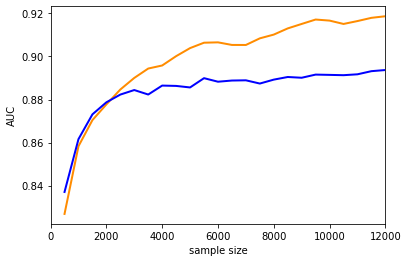

In [89]:
# Test the function

# now we use all the data
train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions
#1) When sample size increases->Increase in AUC for SVM as compared to NB
#2) Optimal sample size is hard to determine along with costs
#3)The AUC for NB first rises until the sample size reaches about 2000, but after that it tends to remain fairly stable or fluctuate just slightly. When SVM is examined, the AUC rises along with the spike in sample size, making it superior to NB.

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [ ]:
 # add your code here